**Import Required Libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
        
# Any results you write to the current directory are saved as output.

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam, RMSprop 
from keras import backend as K
import keras
from keras.models import Model

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
print(K.image_data_format())

channels_last


In [4]:
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.applications.densenet import DenseNet121,DenseNet169
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import imgaug as ia
import math
import warnings
import seaborn as sns
import random
warnings.filterwarnings("ignore")

In [5]:
# Configuration
epochs_warmup = 2
epochs = 20
batch_size = 32
learning_rate = 1e-4
IMAGE_SIZE = 300
workers_warmup = 2
workers_final = 1
CHANNEL = 3
NUM_CLASSES = 5

In [6]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [7]:
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


**EDA**

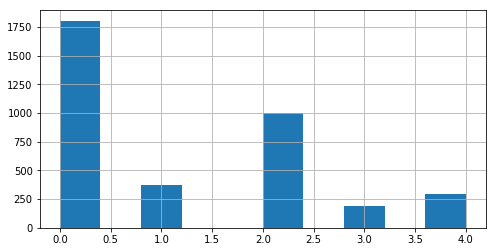

In [8]:
# Now check the distribution of train images
df_train['diagnosis'].hist(figsize = (8,4))

Training dataset is imbalanced

In [9]:
def adjust_gamma(image, gamma=1.0):
        # build a lookup table mapping the pixel values [0, 255] to
        # their adjusted gamma values
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
                for i in np.arange(0, 256)]).astype("uint8")
    
        # apply gamma correction using the lookup table
        return cv2.LUT(image, table)
    
def info_image(im):
    # Compute the center (cx, cy) and radius of the eye
    cy = im.shape[0]//2
    midline = im[cy,:]
    midline = np.where(midline>midline.mean()/3)[0]
    if len(midline)>im.shape[1]//2:
        x_start, x_end = np.min(midline), np.max(midline)
    else: # This actually rarely happens p~1/10000
        x_start, x_end = im.shape[1]//10, 9*im.shape[1]//10
    cx = (x_start + x_end)/2
    r = (x_end - x_start)/2
    return cx, cy, r

def resize_image(im, augmentation=False):
    # Crops, resizes and potentially augments the image to IMAGE_SIZE
    cx, cy, r = info_image(im)
    scaling = IMAGE_SIZE/(2*r)
    rotation = 0
    if augmentation:
        scaling *= 1 + 0.3 * (np.random.rand()-0.5)
        rotation = 360 * np.random.rand()
    M = cv2.getRotationMatrix2D((cx,cy), rotation, scaling)
    M[0,2] -= cx - IMAGE_SIZE/2
    M[1,2] -= cy - IMAGE_SIZE/2
    return cv2.warpAffine(im,M,(IMAGE_SIZE,IMAGE_SIZE))

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

# To remove irregularities along the circular boundary of the image
PARAM = 96
def Radius_Reduction(img,PARAM):
    h,w,c=img.shape
    Frame=np.zeros((h,w,c),dtype=np.uint8)
    cv2.circle(Frame,(int(math.floor(w/2)),int(math.floor(h/2))),int(math.floor((h*PARAM)/float(2*100))), (255,255,255), -1)
    Frame1=cv2.cvtColor(Frame, cv2.COLOR_BGR2GRAY)
    img1 =cv2.bitwise_and(img,img,mask=Frame1)
    return img1

**Display sample images of various classes**

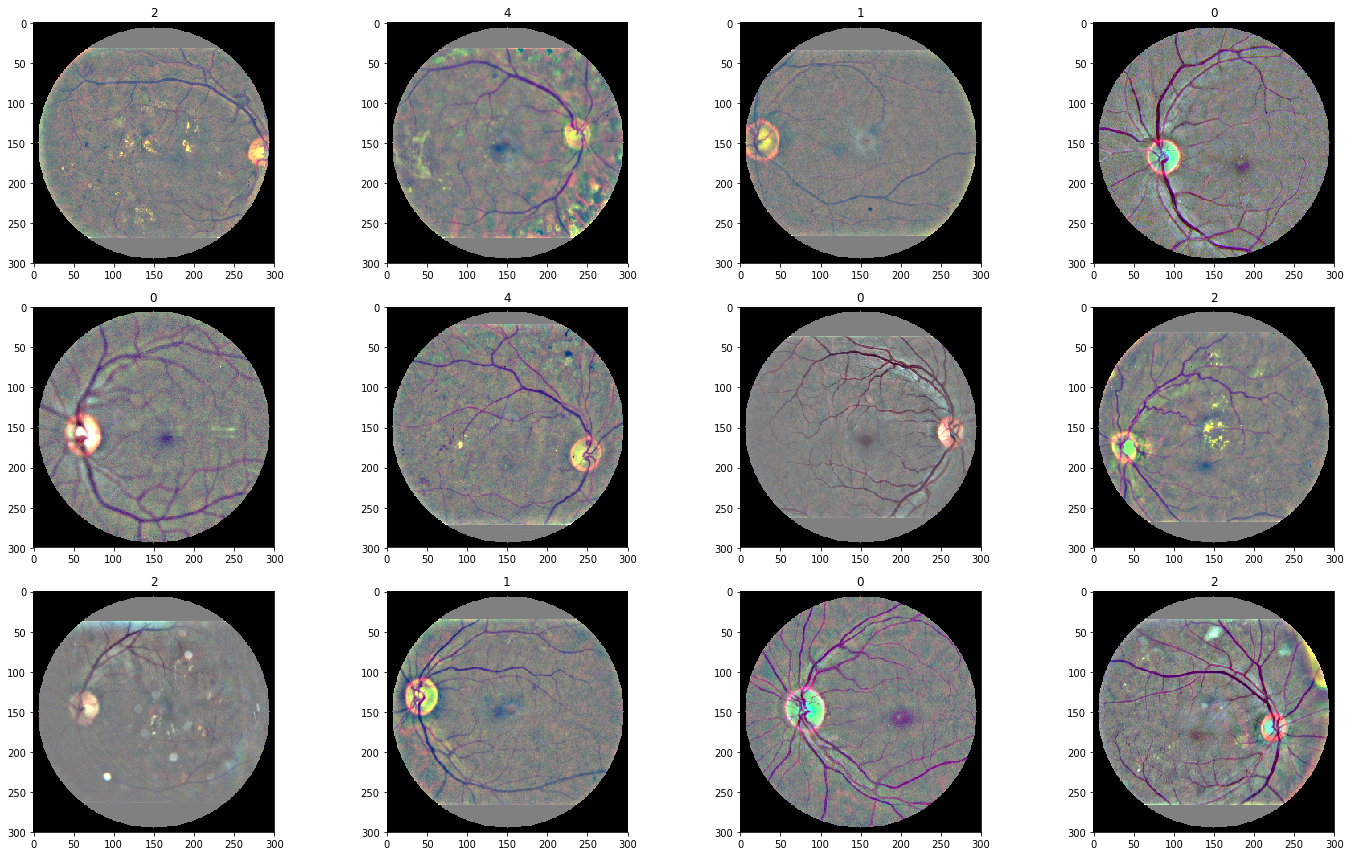

In [10]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = resize_image(img)
        img = subtract_median_bg_image(img)
        img = Radius_Reduction(img, PARAM)

        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(df_train)

In [11]:
# Constants for various class titles
CLASSES = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}

#helper function to draw images for different target classes
def draw_img(imgs, class_label='0'):
    fig, axis = plt.subplots(2, 6, figsize=(15, 6))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = (f'../input/aptos2019-blindness-detection/train_images/{row["id_code"]}.png')
        img = cv2.imread(imgPath)
        row = idnx // 6
        col = idnx % 6
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = resize_image(img)
        img = subtract_median_bg_image(img)
        img = Radius_Reduction(img, PARAM)
        axis[row, col].imshow(img)
    plt.suptitle(class_label)
    plt.show()

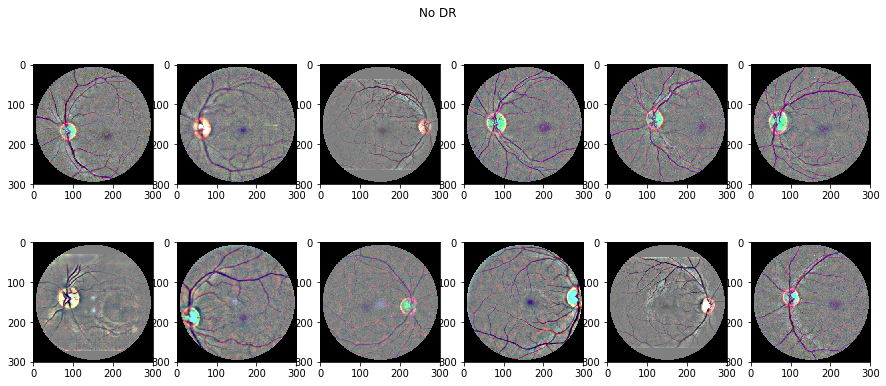

In [12]:
CLASS_ID = 0
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), CLASSES[CLASS_ID])

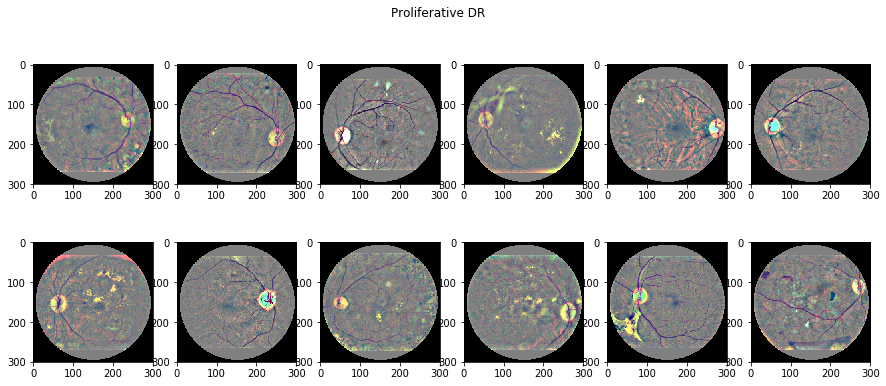

In [13]:
CLASS_ID = 4
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), CLASSES[CLASS_ID])

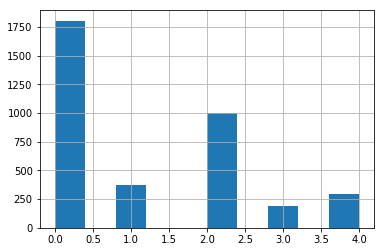

In [14]:
x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=8)
y.hist()

In [15]:
y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(3112,)
(3112, 5)
(550,)
(550, 5)


In [16]:
train_y

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

Image data augmentation

In [17]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes 
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True)

In [18]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
   
    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')

            img = resize_image(img)
            img = subtract_median_bg_image(img)
            img = Radius_Reduction(img, PARAM)            
            
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('../input/aptos2019-blindness-detection/train_images/'+sample+'.png')
           
            img = resize_image(img)
            img = subtract_median_bg_image(img)
            img = Radius_Reduction(img, PARAM)            
            
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

Create base model by transferring learning from DenseNet121

In [19]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = DenseNet121(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    base_model.load_weights("../input/densenetkeras/DenseNet-BC-121-32-no-top.h5")
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output) 
    return model

In [20]:
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

# create callbacks list
# Store the best model for later use
checkpoint = ModelCheckpoint('../working/densenet_model.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

# Monitor val_loss and adjust the learning rate
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)

# If val_loss is not improving after 9 tries, stop the training process
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

# Log the training process
csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

train_warmup_generator = My_Generator(train_x, train_y, 128, is_train=True)
train_generator = My_Generator(train_x, train_y, batch_size, is_train=True, augment=True)
valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

model = create_model(
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), 
    n_out=NUM_CLASSES)

In [21]:
from keras.callbacks import Callback
class KappaEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
            print("\n epoch: %d - Kappa Score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('../working/densenet_best_kappa.h5')

getKappa = KappaEvaluation(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

In [22]:
# warm up model
for layer in model.layers:
    layer.trainable = False

for i in range(-3,0):
    model.layers[i].trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam())

model.fit_generator(
    train_warmup_generator,
    steps_per_epoch=np.ceil(float(len(train_y)) / float(128)),
    epochs=epochs_warmup,
    workers=workers_warmup, 
    use_multiprocessing=True,
    verbose=2,
    callbacks=[getKappa])

Epoch 1/2
 - 209s - loss: 1.6689
18/18 [==============================] - 110s 6s/step

 epoch: 1 - Kappa Score: 0.279506 

saving checkpoint:  0.2795064502683404
Epoch 2/2
 - 115s - loss: 0.9349
18/18 [==============================] - 103s 6s/step

 epoch: 2 - Kappa Score: 0.175635 



In [23]:
# train all layers
for layer in model.layers:
    layer.trainable = True
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, getKappa]
model.compile(loss='categorical_crossentropy',
            optimizer=Adam(lr=learning_rate))
history = model.fit_generator(
                train_generator,
                steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
                validation_data=valid_generator,
                validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
                epochs=epochs,
                verbose=2,
                workers=workers_final, 
                use_multiprocessing=False,
                callbacks=callbacks_list)

Epoch 1/20
 - 413s - loss: 0.8947 - val_loss: 0.5686

Epoch 00001: val_loss improved from inf to 0.56864, saving model to ../working/densenet_model.h5
18/18 [==============================] - 72s 4s/step

 epoch: 1 - Kappa Score: 0.813480 

saving checkpoint:  0.813479823154934
Epoch 2/20
 - 342s - loss: 0.7681 - val_loss: 0.5664

Epoch 00002: val_loss improved from 0.56864 to 0.56636, saving model to ../working/densenet_model.h5
18/18 [==============================] - 74s 4s/step

 epoch: 2 - Kappa Score: 0.843682 

saving checkpoint:  0.8436824848130544
Epoch 3/20
 - 342s - loss: 0.6924 - val_loss: 0.6584

Epoch 00003: val_loss did not improve from 0.56636
18/18 [==============================] - 72s 4s/step

 epoch: 3 - Kappa Score: 0.867650 

saving checkpoint:  0.8676495026470099
Epoch 4/20
 - 347s - loss: 0.6535 - val_loss: 0.4773

Epoch 00004: val_loss improved from 0.56636 to 0.47726, saving model to ../working/densenet_model.h5
18/18 [==============================] - 73s 4s/

Kappa or Cohen’s Kappa is like classification accuracy, except that it is normalized at the baseline of random chance on your dataset. It is a more useful measure to use on problems like this one where there is an imbalance in the classes.(ref: cell 8)

Best Kappa Score from the above cell for validation data is: 0.909

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

Display plots for loss

"loss" is the training loss of a batch of training data. "val_loss" is the validation loss over a batch of validation data.

In [79]:
print(history.history.keys())

dict_keys(['val_loss', 'loss', 'lr'])


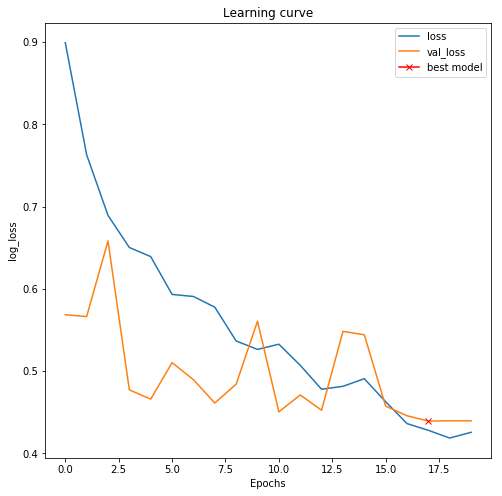

In [26]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

**Predictions for test data**

In [80]:
submit = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
predicted = []

In [81]:
for i, name in tqdm(enumerate(submit['id_code'])):
    path = os.path.join('../input/aptos2019-blindness-detection/test_images/', name+'.png')
    image = cv2.imread(path)
    
    # do the augmentation before predicting
    image = resize_image(image)
    image = subtract_median_bg_image(image)
    image = Radius_Reduction(image, PARAM)
           
    X = np.array((image[np.newaxis])/255)
    score_predict=((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    
    label_predict = np.argmax(score_predict)
    predicted.append(str(label_predict))

1928it [03:47,  7.91it/s]


In [82]:
submit['diagnosis'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,3


Text(0.5, 1.0, 'Test Predictions Per Class')

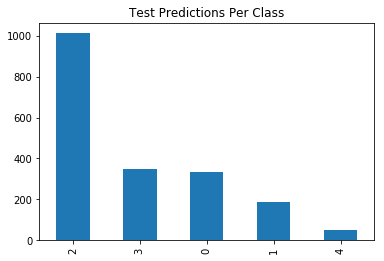

In [83]:
submit['diagnosis'].value_counts().plot(kind='bar')
plt.title('Test Predictions Per Class')